In [7]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(rlang)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)
library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
library(ggplot2)
library(survminer)
library(muhaz)
options(warn=-1)
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)

source('../../../src/tools.R')     # custom tools function
source('../../../src/hdp_tools_yanis.R')
source("../../../src/merge_df.R")
source("../../../src/my_toolbox.R")
source("../../../src/my_components.R")
source("../../../src/my_utils.R")
source("../../../src/ggstyles.R")
source("../../../src/my_hotspots.R")
###


theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

In [8]:
df_final <- read.table("df_final_full_component_ITD.tsv")
eln <- colnames(df_final[,c(2,3,4)])
comp <- colnames(df_final[,c(170:193)])

all_gen <- c(5:88)
vect <- apply(X=df_final[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
gen <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])
              
all_cyto <- c(89:158)
vect <- apply(X=df_final[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
cyto <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])
              
clin <- colnames(df_final[,c(159:165)])
demo <- colnames(df_final[,c(166:167)])
pal <- c(eln="#EE9937",comp="#59A08B",gen="#BFBFBF",cyto="#2b8cbe",clin="#870C14",demo="#a6bddb",age="#a6bddb",gen_cyto="pink",eln_gen_cyto="#fdbb84",comp_gen_cyto="lightgoldenrod",all="lightsalmon")  

In [9]:
df <- data.frame(hazard = double(),pvalue = double(),Frequency = double() )
for (col in c(gen,cyto,clin,demo,eln,comp)){
    surv_object <- Surv(time = df_final$os, event = df_final$os_status)
    fit <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       col)), data = df_final)
    df[col,1:3] <- c(summary(fit)$coef[2],summary(fit)$sctest[["pvalue"]],100*sum(df_final[,col])/dim(df_final)[1])
    }
df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
df[,"log2(hazard)"] <- log(df$hazard,2)
df["names"] <- rownames(df)
df$Model <- ifelse(df$names %in% gen,"gen",
                  ifelse(df$names %in% cyto,"cyto",
                        ifelse(df$names %in% clin, "clin",
                              ifelse(df$names %in% demo, "demo",
                                    ifelse(df$names %in% eln, "eln","comp")))))
df$Frequency <- ifelse(df$names %in% clin, 5,
                              ifelse(df$names %in% demo, 5, df$Frequency))
df <- df[order(df$adjusted_pvalue),]


In [10]:
pdf(file="graphs/volcano_plot.pdf",width=25,height=15)
tmp <- df[setdiff(rownames(df),c("t_8_21","NPM1","inv_16")),]
ggplot(tmp, aes(log2(hazard), -log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
    geom_point(aes(size=Frequency,col=Model))+geom_text_repel(data=tmp[tmp["adjusted_pvalue"]<0.0001,], aes(label=names,fontface=2))+scale_size_continuous(range = c(10,40))+scale_color_manual(values=pal,limits=names(pal))+
        theme(
              plot.title = element_text(size = rel(1.5), hjust = 0.5),
              axis.title = element_text(size = rel(1.25))) + ggtitle("Volcano plot with all features")
dev.off()

pdf 
  2

In [12]:
tmp <- df_final[df_final$eln_2017_adverse==1 ,]
fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
df <- fit%>%
as.data.frame()

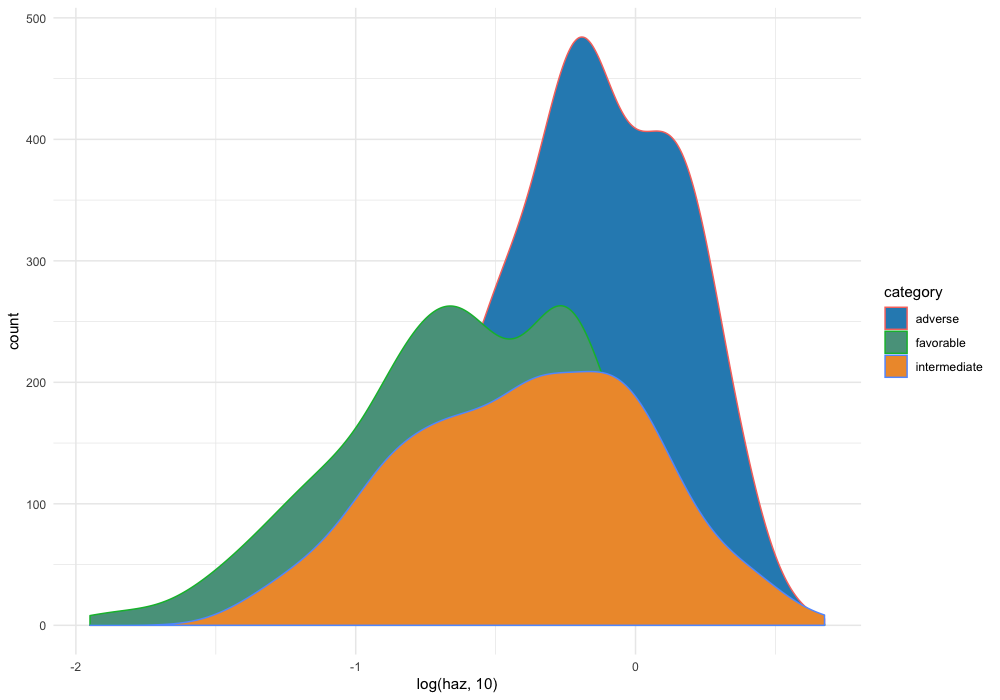

In [13]:
set_notebook_plot_size(10,7)
tmp <- df_final[df_final$eln_2017_adverse==1 ,]
fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
df <- fit%>%
as.data.frame()
df[,"category"] <- "adverse"
tmp <- df_final[df_final$eln_2017_favorable==1 ,]
fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
df1 <- fit%>%
as.data.frame()
df1[,"category"] <- "favorable"
df <- rbind(df,df1)
tmp <- df_final[df_final$eln_2017_intermediate==1 ,]
fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
df1 <- fit%>%
as.data.frame()
df1[,"category"] <- "intermediate"
df <- rbind(df,df1)

p <- ggplot(df, aes(x=log(haz,10),fill=category,color=category)) + 
  geom_density(aes(y=..count..)) + scale_fill_manual(values=c("#2b8cbe","#59A08B","#EE9937","#BFBFBF","#870C14","#a6bddb","#a6bddb","pink","#fdbb84"))

p

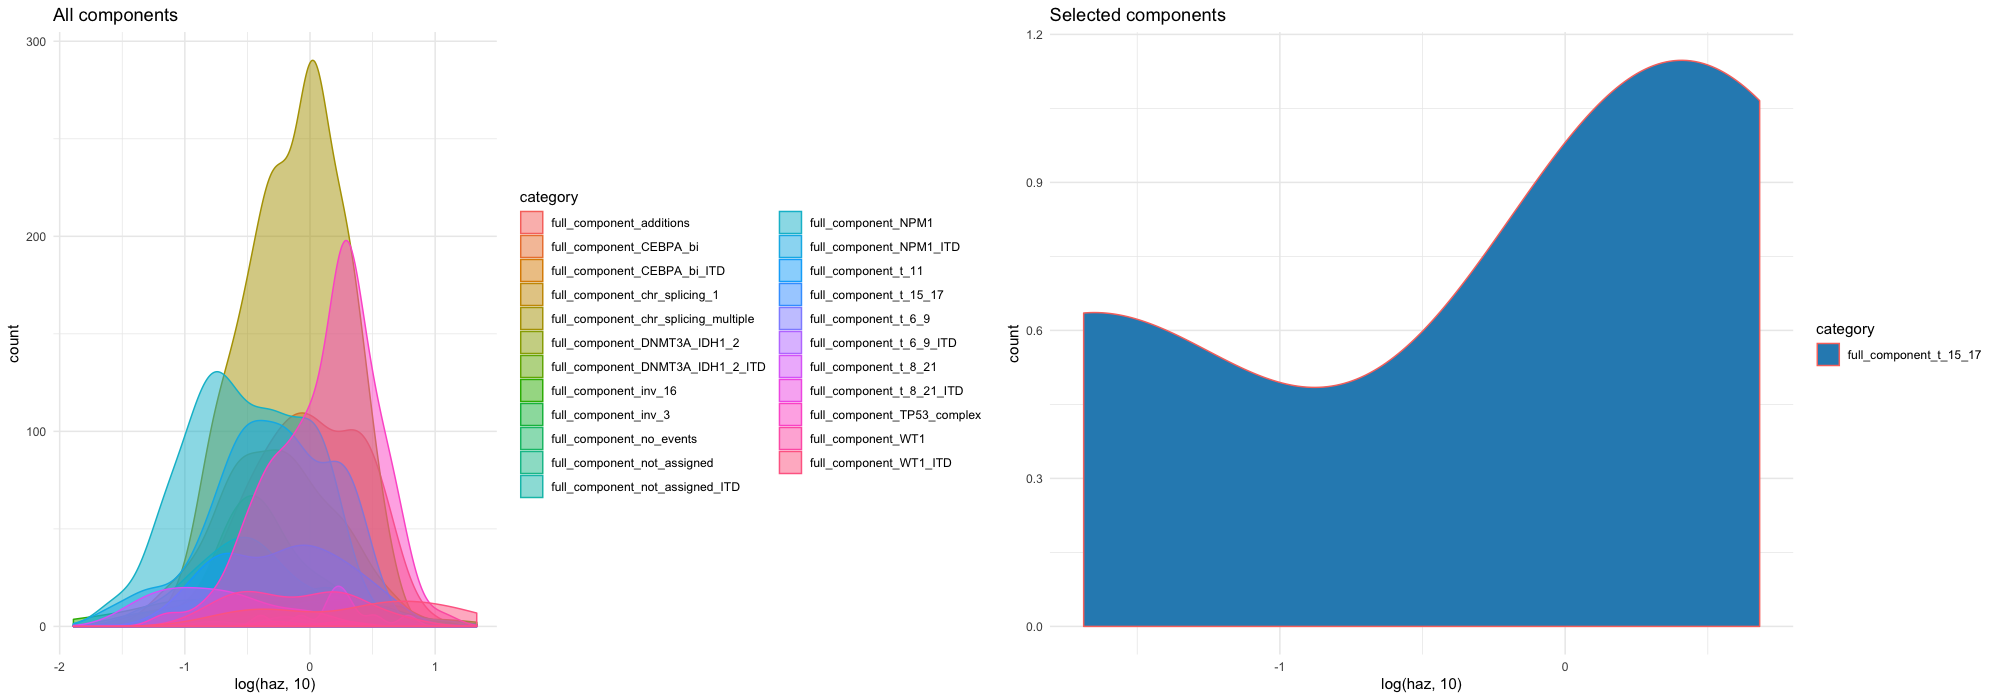

In [14]:
set_notebook_plot_size(20,7)
df <- NULL

for (co in setdiff(comp,"overlap")){
    tmp <- df_final[df_final[,co]==1 ,]
    fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
    df1 <- fit%>%
    as.data.frame()
    df1[,"category"] <- co
    df <- rbind(df,df1)
}
p <- ggplot(df, aes(x=log(haz,10),color=category,fill=category)) + 
  geom_density(aes(y=..count..),alpha=.5)+ggtitle("All components")


df <- NULL
for (co in c("full_component_t_15_17")){
    tmp <- df_final[df_final[,co]==1 ,]
    fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
    df1 <- fit%>%
    as.data.frame()
    df1[,"category"] <- co
    df <- rbind(df,df1)
}
q <- ggplot(df, aes(x=log(haz,10),color=category,fill=category)) + 
  geom_density(aes(y=..count..)) + scale_fill_manual(values=c("#2b8cbe","#59A08B","#EE9937","#BFBFBF","#870C14","#a6bddb","black","pink","#fdbb84"))+ggtitle("Selected components")


grid.arrange(p,q,ncol=2)


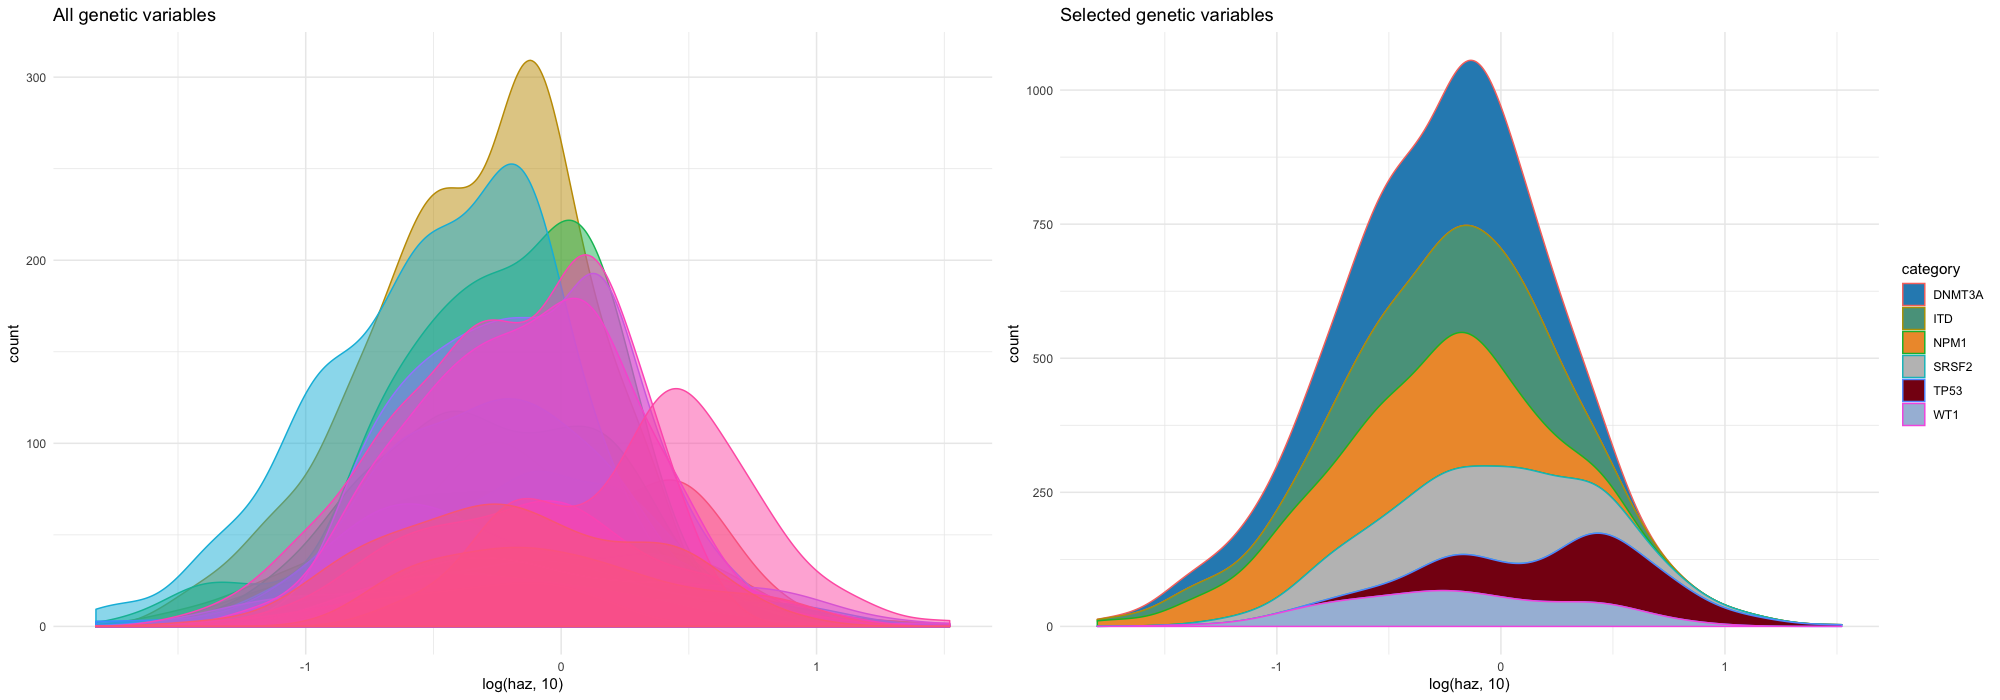

In [15]:
set_notebook_plot_size(20,7)
df <- NULL
for (co in gen){
    tmp <- df_final[df_final[,co]==1 ,]
    fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
    df1 <- fit%>%
    as.data.frame()
    df1[,"category"] <- co
    df <- rbind(df,df1)
}
p <- ggplot(df, aes(x=log(haz,10),color=category,fill=category)) + 
  geom_density(aes(y=..count..),alpha=.5)+guides(fill=FALSE)+guides(fill=F,color=F)+ggtitle("All genetic variables") #+ scale_fill_manual(values=c("#2b8cbe","#59A08B","#EE9937","#BFBFBF","#870C14","#a6bddb","#a6bddb","pink","#fdbb84"))

df <- NULL
for (co in c("DNMT3A","NPM1","TP53","WT1","SRSF2","ITD")){
    tmp <- df_final[df_final[,co]==1 ,]
    fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
    df1 <- fit%>%
    as.data.frame()
    df1[,"category"] <- co
    df <- rbind(df,df1)
}
q <- ggplot(df, aes(x=log(haz,10),color=category,fill=category)) + 
  geom_density(aes(y=..count..),position="stack") + scale_fill_manual(values=c("#2b8cbe","#59A08B","#EE9937","#BFBFBF","#870C14","#a6bddb","#a6bddb","pink","#fdbb84"))+ggtitle("Selected genetic variables")

grid.arrange(p,q,ncol=2)

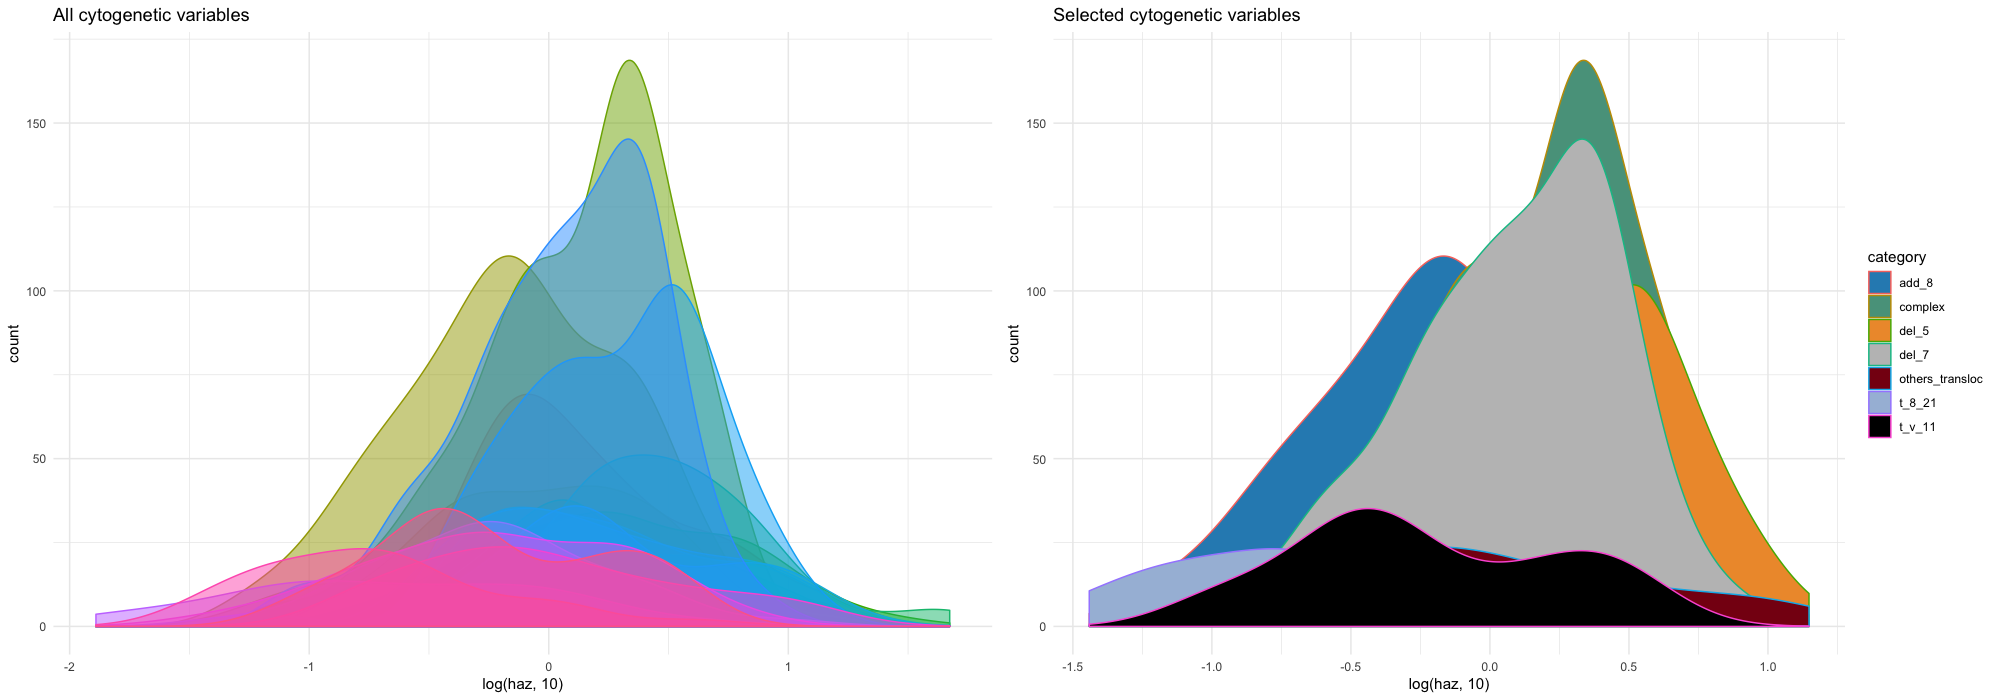

In [16]:
set_notebook_plot_size(20,7)
df <- NULL
for (co in cyto){
    tmp <- df_final[df_final[,co]==1 ,]
    fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
    df1 <- fit%>%
    as.data.frame()
    df1[,"category"] <- co
    df <- rbind(df,df1)
}
p <- ggplot(df, aes(x=log(haz,10),color=category,fill=category)) + 
  geom_density(aes(y=..count..),alpha=.5)+guides(fill=FALSE)+guides(fill=F,color=F)+ggtitle("All cytogenetic variables") #+ scale_fill_manual(values=c("#2b8cbe","#59A08B","#EE9937","#BFBFBF","#870C14","#a6bddb","#a6bddb","pink","#fdbb84"))

df <- NULL
for (co in c("complex","t_8_21","t_v_11","add_8","others_transloc","del_7","del_5")){
    tmp <- df_final[df_final[,co]==1 ,]
    fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
    df1 <- fit%>%
    as.data.frame()
    df1[,"category"] <- co
    df <- rbind(df,df1)
}
q <- ggplot(df, aes(x=log(haz,10),color=category,fill=category)) + 
  geom_density(aes(y=..count..)) + scale_fill_manual(values=c("#2b8cbe","#59A08B","#EE9937","#BFBFBF","#870C14","#a6bddb","black","pink","#fdbb84"))+ggtitle("Selected cytogenetic variables")

grid.arrange(p,q,ncol=2)

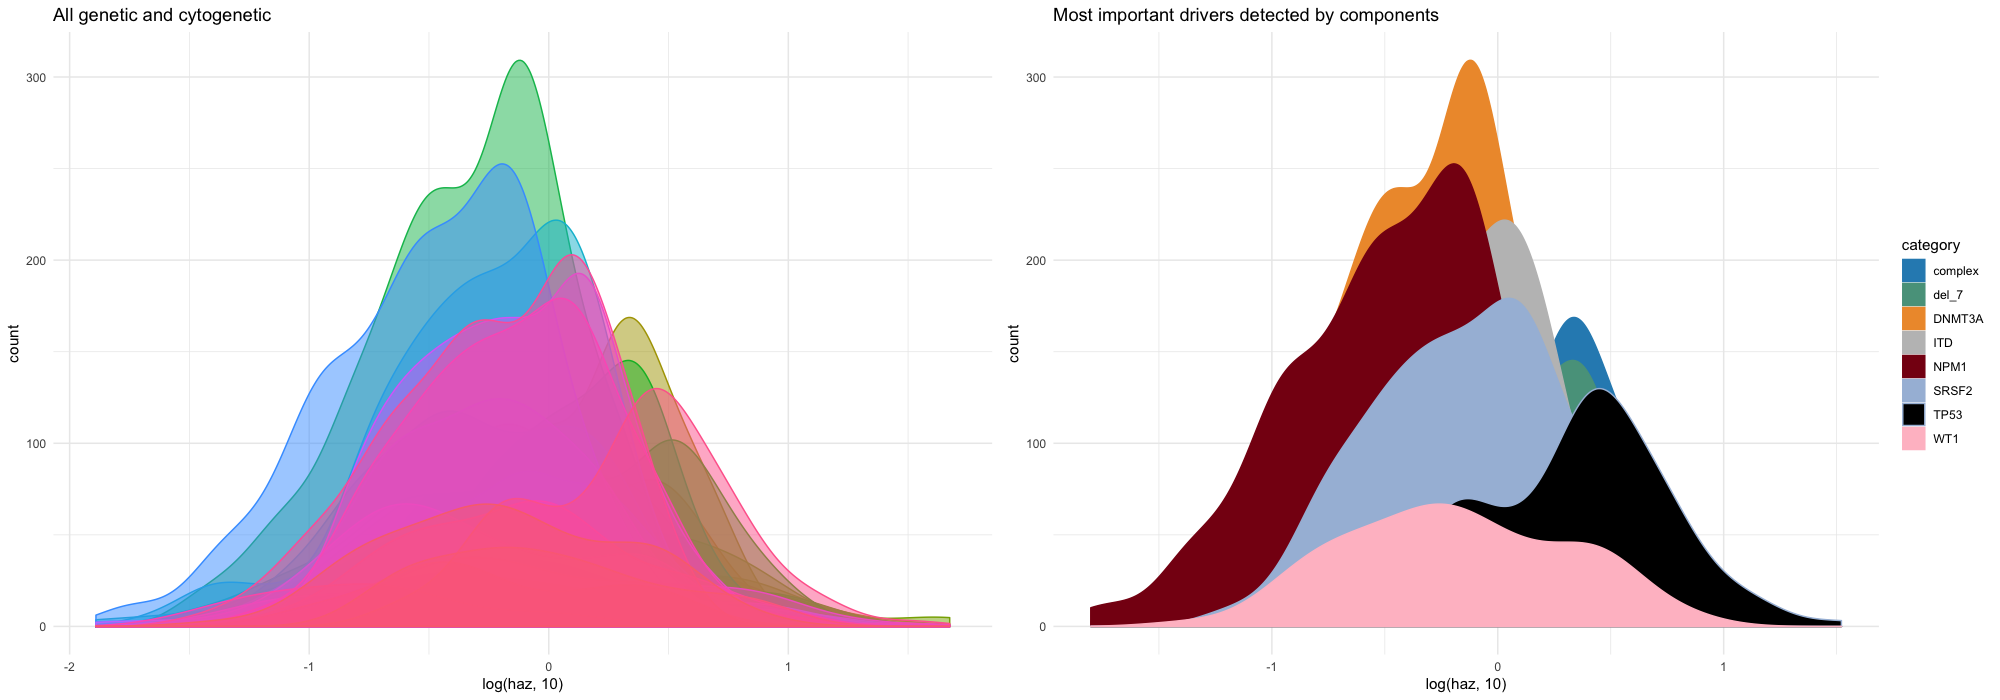

In [18]:
# pdf(file="graphs/density_plots_important_drivers.pdf",width=20,height=7)
set_notebook_plot_size(20,7)
df <- NULL
for (co in c(gen,cyto)){
    tmp <- df_final[df_final[,co]==1 ,]
    fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
    df1 <- fit%>%
    as.data.frame()
    df1[,"category"] <- co
    df <- rbind(df,df1)
}
p <- ggplot(df, aes(x=log(haz,10),color=category,fill=category)) + 
  geom_density(aes(y=..count..),alpha=.5)+guides(fill=FALSE)+guides(fill=F,color=F)+ggtitle("All genetic and cytogenetic") #+ scale_fill_manual(values=c("#2b8cbe","#59A08B","#EE9937","#BFBFBF","#870C14","#a6bddb","#a6bddb","pink","#fdbb84"))

df <- NULL
for (co in c("DNMT3A","NPM1","WT1","TP53","complex","SRSF2","ITD","del_7")){
    tmp <- df_final[df_final[,co]==1 ,]
    fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
    df1 <- fit%>%
    as.data.frame()
    df1[,"category"] <- co
    df <- rbind(df,df1)
}
q <- ggplot(df, aes(x=log(haz,10),color=category,fill=category)) + 
  geom_density(aes(y=..count..)) + scale_fill_manual(values=c("#2b8cbe","#59A08B","#EE9937","#BFBFBF","#870C14","#a6bddb","black","pink","#fdbb84"))+
 scale_color_manual(values=c("#2b8cbe","#59A08B","#EE9937","#BFBFBF","#870C14","#a6bddb","#a6bddb","pink","#fdbb84"))+ggtitle("Most important drivers detected by components")

grid.arrange(p,q,ncol=2)
# dev.off()



In [27]:
tmp_final <- read.table("df_final_full_component.tsv")
df <- data.frame(mean_survival = double() )
for (co in colnames(tmp_final[,c(170:185)])){
    df[co,] <- mean(tmp_final[tmp_final[,co]==1,]$os)
    df[co,"name"] <- co
}
components_ordered <- df[order(df$mean_survival,decreasing=T),]$name

set_notebook_plot_size(10,3)
p <- list()
pdf(file="graphs/density_plots.pdf",width=15,height=3)
for (co in c('eln_2017_favorable','eln_2017_intermediate','eln_2017_adverse',components_ordered)){
    if (is.element(co,c("full_component_t_8_21","full_component_t_6_9","full_component_NPM1","full_component_CEBPA_bi","full_component_DNMT3A_IDH1_2","full_component_WT1","full_component_not_assigned"))){    
        tmp <- tmp_final[tmp_final[,co]==1 &  tmp_final$ITD==0,]
        fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
        df <- fit%>%
        as.data.frame()
        df[,"category"] <- co
        tmp <- tmp_final[tmp_final[,co]==1 &  tmp_final$ITD==1,]
        fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
        df1 <- fit%>%
        as.data.frame()
        df1[,"category"] <- paste(co,"ITD",sep="_")        
        df <- rbind(df,df1)

     }else{
        tmp <- tmp_final[tmp_final[,co]==1 ,]
        fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
        df <- fit%>%
        as.data.frame()
        df[,"category"] <- co
        }   
    p <- ggplot(df, aes(x=log(haz,10),color=category,fill=category)) + 
  geom_density(aes(y=..count..),alpha=1)+guides(fill=FALSE)+guides(fill=F,color=F)+ggtitle(co)+xlim(c(-2,1)) +theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))
    if(co=="eln_2017_favorable"){
        plot(p+ scale_fill_manual(values=c("#2b8cbe")))
    }
    if(co=="eln_2017_intermediate"){
        plot(p+ scale_fill_manual(values=c("#59A08B")))
    }
    if(co=="eln_2017_adverse"){
        plot(p+ scale_fill_manual(values=c("#EE9937")))}
    if(is.element(co,components_ordered)){
        plot(p+ scale_fill_manual(values=c("#870C14","#a6bddb","#a6bddb","pink","#fdbb84")))
        }

    }

dev.off()    


# df <- NULL
# for (co in c("DNMT3A","NPM1","WT1","TP53","complex","SRSF2","ITD","del_7")){
#     tmp <- df_final[df_final[,co]==1 ,]
#     fit <- kphaz.fit(tmp$os,tmp$os_status,q=1,method="nelson")
#     df1 <- fit%>%
#     as.data.frame()
#     df1[,"category"] <- co
#     df <- rbind(df,df1)
# }
# q <- ggplot(df, aes(x=log(haz,10),color=category,fill=category)) + 
#   geom_density(aes(y=..count..)) + scale_fill_manual(values=c("#2b8cbe","#59A08B","#EE9937","#BFBFBF","#870C14","#a6bddb","black","pink","#fdbb84"))+
#  scale_color_manual(values=c("#2b8cbe","#59A08B","#EE9937","#BFBFBF","#870C14","#a6bddb","#a6bddb","pink","#fdbb84"))+ggtitle("Most important drivers detected by components")

# grid.arrange(p,q,ncol=2)

pdf 
  2

# MULTI PLOT COMPONENT

In [28]:
tmp_final <- read.table("df_final_full_component.tsv")
df <- data.frame(mean_survival = double() )
for (co in colnames(tmp_final[,c(170:185)])){
    df[co,] <- mean(tmp_final[tmp_final[,co]==1,]$os)
    df[co,"name"] <- co
}
 
components_ordered <- df[order(df$mean_survival,decreasing=T),]$name

pdf(file="graphs/summary_multi_analysis.pdf",width=35,height=6)
set_notebook_plot_size(35,6)
for (co in c('eln_2017_favorable','eln_2017_intermediate','eln_2017_adverse',components_ordered)){

    ## Prepare colors
    
    if(co=="eln_2017_favorable"){
         pal = c("#5C5C5C","#009E73","#0072B2")
         cols <- c("#009E73","#0072B2") %>% set_names(c(co, paste(co,"ITD",sep="_")))   
    }

    if(co=="eln_2017_intermediate"){
        pal = c("#5C5C5C","#a6bddb","#0072B2")
        cols <- c("#a6bddb","#0072B2") %>% set_names(c(co, paste(co,"ITD",sep="_")))
    }
        
    if(co=="eln_2017_adverse"){
        pal = c("#5C5C5C","#870C14","#0072B2")
        cols <- c("#870C14","#0072B2") %>% set_names(c(co, paste(co,"ITD",sep="_")))
    }
    if(is.element(co,components_ordered)){
        pal = c("#5C5C5C","#EE9937","#0072B2")
        cols <- c("#EE9937","#0072B2") %>% set_names(c(co, paste(co,"ITD",sep="_")))
    }
       
    ## Handle ITD cases
       
    if (is.element(co , c("full_component_t_8_21","full_component_t_6_9","full_component_NPM1","full_component_CEBPA_bi","full_component_DNMT3A_IDH1_2","full_component_WT1","full_component_not_assigned"))){
        
        # Surv plot
        
        tmp <- tmp_final
        tmp$comparison <- ifelse(tmp[,co]==1 & tmp$ITD==1 ,paste(co,"ITD",sep="_"),
                                 ifelse(tmp[,co]==1 & tmp$ITD==0 ,co,"_Others"))
        surv_object <- Surv(time = tmp$os, event = tmp$os_status)
        fit_surv <- survfit(surv_object ~ comparison, data = tmp)

        # Risk density
        
        tmp_density <- tmp_final[tmp_final[,co]==1 &  tmp_final$ITD==0,]
        fit_density <- kphaz.fit(tmp_density$os,tmp_density$os_status,q=1,method="nelson")
        df_density <- fit_density%>%
        as.data.frame()
        df_density[,"category"] <- co
        tmp_density <- tmp_final[tmp_final[,co]==1 &  tmp_final$ITD==1,]
        fit_density <- kphaz.fit(tmp_density$os,tmp_density$os_status,q=1,method="nelson")
        df1 <- fit_density%>%
        as.data.frame()
        df1[,"category"] <- paste(co,"ITD",sep="_")        
        df_density <- rbind(df_density,df1)
        
        # Risk overtime
        
        tmp_overtime <- tmp_final[tmp_final[,co]==1 ,]
        fit <- kphaz.fit(tmp_overtime$os,tmp_overtime$os_status,q=1,method="nelson")
        df_overtime <- fit %>% as.data.frame() 
        df_overtime[,"category"] <- co
        tmp_overtime <- tmp_final[tmp_final[,co]==1 & tmp_final$ITD==1,]
        fit <- kphaz.fit(tmp_overtime$os,tmp_overtime$os_status,q=1,method="nelson")
        df1 <- fit%>%
        as.data.frame()
        df1[,"category"] <- paste(co,"ITD",sep="_")
        df_overtime <- rbind(df_overtime,df1)
        
       
    } else {   #( for cases with no ITD separation)
                
            tmp <- tmp_final
            tmp$comparison <- ifelse(tmp[,co]==1,co,"_Others")
            surv_object <- Surv(time = tmp$os, event = tmp$os_status)
            fit_surv <- survfit(surv_object ~ comparison, data = tmp)

            tmp_density <- tmp_final[tmp_final[,co]==1 ,]
            fit_density <- kphaz.fit(tmp_density$os,tmp_density$os_status,q=1,method="nelson")
            df_density <- fit_density%>%
            as.data.frame()
            df_density[,"category"] <- co
        
            tmp_overtime <- tmp_final[tmp_final[,co]==1 ,]
            fit <- kphaz.fit(tmp_overtime$os,tmp_overtime$os_status,q=1,method="nelson")
            df_overtime <- fit %>% as.data.frame() 
            df_overtime[,"category"] <- co 
        
            } 
         
        

    p <- ggsurvplot(fit_surv,  pval = TRUE,main = "Survival curve",risk.table=T,submain = "Kaplan-Meier estimates",palette = pal,legend="none",
              ggtheme = theme_survminer(
             font.main = c(16, "bold", "darkblue"),
             font.submain = c(15, "bold.italic", "purple"),
             font.caption = c(14, "plain", "orange"),
             font.x = c(14, "bold.italic", "red"),
             font.y = c(14, "bold.italic", "darkred"),
             font.tickslab = c(12, "plain", "darkgreen")))

    q <- ggplot(df_density, aes(x=log(haz,10),color=category,fill=category)) + 
    geom_density(aes(y=..count..),alpha=1)+guides(fill=FALSE)+guides(fill=F,color=F)+ggtitle(co)+xlim(c(-2,1)) +theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) + scale_fill_manual(values=pal[2:3])


    r <- ggplot(df_overtime,aes(x = log(time), y = log(haz), colour=category)) + geom_point() +
    geom_smooth(method="auto") + scale_colour_manual(values=cols) + 
    xlab("log(Time)") + ylab("log(h(t))")+ theme(legend.position = "none") +theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))
    
    
    ## Volcano Plot Univariate
    
    df <- data.frame(hazard = double(),pvalue = double(),Frequency = double() )
    data <- tmp_final[tmp_final[,co]==1,]

    for (col in c(gen,cyto)){
        surv_object <- Surv(time = data$os, event = data$os_status)
        fit <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                           col)), data = data)

        df[col,1:3] <- c(summary(fit)$coef[2],summary(fit)$sctest[["pvalue"]],100*sum(data[,col])/dim(data)[1])                 
         }
    df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
    df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
    df[,"log2(hazard)"] <- log(df$hazard,2)
    df["names"] <- rownames(df)
    df$Model <- ifelse(df$names %in% gen,"gen",
                      ifelse(df$names %in% cyto,"cyto",
                            ifelse(df$names %in% clin, "clin",
                                  ifelse(df$names %in% demo, "demo",
                                        ifelse(df$names %in% eln, "eln","comp")))))
    df$Frequency <- ifelse(df$names %in% clin, 5,
                                  ifelse(df$names %in% demo, 5, df$Frequency))
    
    colors_analysis <- c(gen="#BFBFBF",cyto="#2b8cbe")
    df <- df[order(df$adjusted_pvalue),]
    s <- ggplot(df, aes(log2(hazard), -log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
        geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["adjusted_pvalue"]<0.1) | (df["log2(hazard)"]< -18),], aes(label=names,fontface=2))+scale_size_continuous(range = c(3,12)) + 
         scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
        theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))  + theme(legend.position="top")

    
    ## Multivariate Plot
    if (dim(tmp_final[tmp_final[,co]==1,])>100){    # we can not run lasso on a model without any events (variance 0)
        data = tmp_final[tmp_final[,co]==1,]
        df_multi <- NULL
        i <- 1
        for (i in c(1:100)){
            res1 <- cv.glmnet(data.matrix(data[,c(gen,cyto)]), Surv(data$os,data$os_status), family="cox",alpha=1,nfolds=10)
            df_multi <- cbind(df_multi,as.matrix(coef(res1,s="lambda.min")))
            i <- i+1
            }

        l <- data.frame(coef = rowSums(df_multi)/100)
        l$names <- rownames(l)
        l$Model <- ifelse(l$names %in% gen,"gen",
                      ifelse(l$names %in% cyto,"cyto",
                            ifelse(l$names %in% clin, "clin",
                                  ifelse(l$names %in% demo, "demo",
                                        ifelse(l$names %in% eln, "eln","comp")))))
        t <- ggplot(l[l$coef!=0,],aes(x=names,y=coef,fill=Model))+geom_bar(stat="identity")+coord_flip()+
        theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))+
        scale_fill_manual(values=colors_analysis,limits=names(colors_analysis))
        }

    
    
    # Hanfle p value issues
    if (dim(tmp_final[tmp_final[,co]==1,])<100 & min(df$adjusted_pvalue>0.1)){     
        grid.arrange(arrangeGrob(p$plot,q,r,grid.rect(gp=gpar(col="white")),grid.rect(gp=gpar(col="white")), ncol=5, nrow=1),
         arrangeGrob(p$table, ncol=1, nrow=1), heights=c(2.8,1)) 
    } else if (dim(tmp_final[tmp_final[,co]==1,])>100 & min(df$adjusted_pvalue>0.1)){
        grid.arrange(arrangeGrob(p$plot,q,r,grid.rect(gp=gpar(col="white")),t, ncol=5, nrow=1),
         arrangeGrob(p$table, ncol=1, nrow=1), heights=c(2.8,1)) 
    } else if (dim(tmp_final[tmp_final[,co]==1,])>100 & min(df$adjusted_pvalue<0.1)){
        grid.arrange(arrangeGrob(p$plot,q,r,s,grid.rect(gp=gpar(col="white")), ncol=5, nrow=1),
         arrangeGrob(p$table, ncol=1, nrow=1), heights=c(2.8,1)) 
    } else {
         grid.arrange(arrangeGrob(p$plot,q,r,s,t, ncol=5, nrow=1),
         arrangeGrob(p$table, ncol=1, nrow=1), heights=c(2.8,1)) 
    }
    }

    dev.off()


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ 

pdf 
  2